# Notebook to study wings vibrations

In this notebook we implement a short scenario that focuses on the crab walk and the wing extension.

The video that was produced using this code is on the drive  (https://drive.google.com/drive/u/1/folders/1RxnbTyR-75OWsPtSnCLu-PBjjf7ijszE) under the name '3_crab_and_wings.mp4'.

In [1]:
from flygym import Camera, Simulation
import cv2
import numpy as np
from tqdm import trange
import flygym as flygym
from flygym.arena import FlatTerrain
from flygym.vision import save_video_with_vision_insets

In [5]:
from scripts.utils import plot_chasing, plot_visual_detection, plot_overlayed_frames
from scripts.changing_state_fly import ChangingStateFly
from scripts.target_fly import TargetFly

## Simulation

In [3]:
timestep = 1e-4
run_time = 3
t = np.arange(0, run_time, timestep)

Arena

In [4]:
arena = FlatTerrain()

Flies

In [5]:
fly0 = ChangingStateFly(
    name="0",
    desired_distance=0.008,
    timestep=timestep,
    enable_adhesion=True,
    head_stabilization_model="thorax",
    neck_kp=1000,
)

fly1 = TargetFly(
    name="1",
    timestep=timestep,
    enable_adhesion=True,
    spawn_pos=(5, 0, 0.5),
)

Cameras

In [6]:
birdeye_cam_zoom = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam_zoom",
    mode="fixed",
    pos=(15, 0, 20),
    euler=(0, 0, 0),
    fovy=45,
)

birdeye_cam = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam",
    mode="fixed",
    pos=(15, 0, 35),
    euler=(0, 0, 0),
    fovy=45,
)

cam = Camera(
    fly=fly0,
    camera_id="birdeye_cam",
    play_speed=0.5,
    window_size=(800, 608),
)

Simulation

In [7]:
sim = Simulation(
    flies=[fly0, fly1],
    cameras=[cam],
    arena=arena,
    timestep=timestep,
)

In [8]:
# Define fly 1 actions --> sinusoidal trajectory
speed_variation = np.abs(np.sin(t * np.pi / 2))
fly1_actions = np.zeros((len(t), 2))  

# Create the fly 1 actions scenario
# for i, time in enumerate(t):
#     if time < (1/5) * run_time:
#         # sinusoidal trajectory for the first 1/3 of the time
#         fly1_actions[i] = (
#             np.abs(np.cos(time * np.pi / 2)) * speed_variation[i],
#             np.abs(np.sin(time * np.pi / 2)) * speed_variation[i],
#         ) 
#     else :
#         fly1_actions[i] = (0, 0)

# Modifiy fly speed
mean_speed = 1.2  
std_dev_speed = 0.4  

# fly1_actions *= random_speed_variation
fly1_actions = np.clip(fly1_actions, 0, 2 * mean_speed) * 1.3

In [9]:
# Reset the simulation and set fly 1 to be black
sim.reset(seed=0)
for i in fly1.model.find_all("geom"):
    sim.physics.named.model.geom_rgba[f"1/{i.name}"] = (0, 0, 0, 1)

# Prepare simulation
second_cam_frames = []
fly0_action = np.zeros(2)
x = None
alpha = 1e-1

# Prepare variables to plot 
proximities = []
speeds_fly0 = []
speeds_fly1 = []
actions_fly0 = []
positions_fly0 = []
positions_fly1 = []
fly1_vision_left = []
fly1_vision_right = []
wings_extension = []

# Run simulation for each timepoint
for i in trange(len(t)):
    obs, _, _, _, info = sim.step(
        {
            "0": fly0_action,
            "1": fly1_actions[i],
        }
    )

    # Get observations for fly 0
    obs0, info0 = obs["0"], info["0"]
    render_res = sim.render()[0]
    velocity0 = obs0["fly"][1]
    v0 = np.linalg.norm(velocity0)

    actions_fly0.append(fly0_action)

    # Get observations for fly 1
    obs1, info1 = obs["1"], info["1"]
    velocity1 = obs1["fly"][1]
    v1 = np.linalg.norm(velocity1)

    # If frame is rendered, save it
    if render_res is not None:
        fly0.visual_inputs_hist.append(obs0["vision"].copy())
        second_cam = sim.physics.bind(birdeye_cam_zoom)

        x_new = sim._get_center_of_mass()[0]

        if x is None:
            x = x_new

        x = (1 - alpha) * x + alpha * x_new

        second_cam.pos[0] = x
        second_img = sim.physics.render(
            width=700, height=560, camera_id="birdeye_cam_zoom"
        )
        second_img = cv2.putText(
            np.ascontiguousarray(second_img),
            f"{sim.cameras[0].play_speed}x",
            org=(20, 30),
            fontFace=cv2.FONT_HERSHEY_DUPLEX,
            fontScale=0.8,
            color=(0, 0, 0),
            lineType=cv2.LINE_AA,
            thickness=1,
        )
        second_cam_frames.append(second_img)

    # Process visual input for fly 0
    curr_time = i * sim.timestep
    fly0_action, proximity = fly0.get_action(obs0, curr_time)

    # Process visual input for fly 1
    # fly1_features, left_deviation, right_deviation, left_found, right_found = fly1.process_visual_observation(obs1['vision'])
    fly1_features, chasing_fly = fly1.process_visual_observation(obs1['vision'])

    # Save variables for plotting
    proximities.append(proximity)
    speeds_fly0.append(v0)
    speeds_fly1.append(v1)
    positions_fly0.append(obs0["fly"][0])
    positions_fly1.append(obs1["fly"][0])
    fly1_vision_left.append(chasing_fly[0])
    fly1_vision_right.append(chasing_fly[1])
    wings_extension.append(fly0.wings_state)

100%|██████████| 30000/30000 [16:31<00:00, 30.25it/s]


The video that was produced using this code is on the drive  (https://drive.google.com/drive/u/1/folders/1RxnbTyR-75OWsPtSnCLu-PBjjf7ijszE) under the name '3_crab_and_wings.mp4'.

In [11]:
birdeye_cam_frames = cam._frames
cam._frames = second_cam_frames
sim.fly = fly0

save_video_with_vision_insets(
    sim,
    cam,
    "outputs/3_crab_and_wings_ext.mp4",
    fly0.visual_inputs_hist,
)

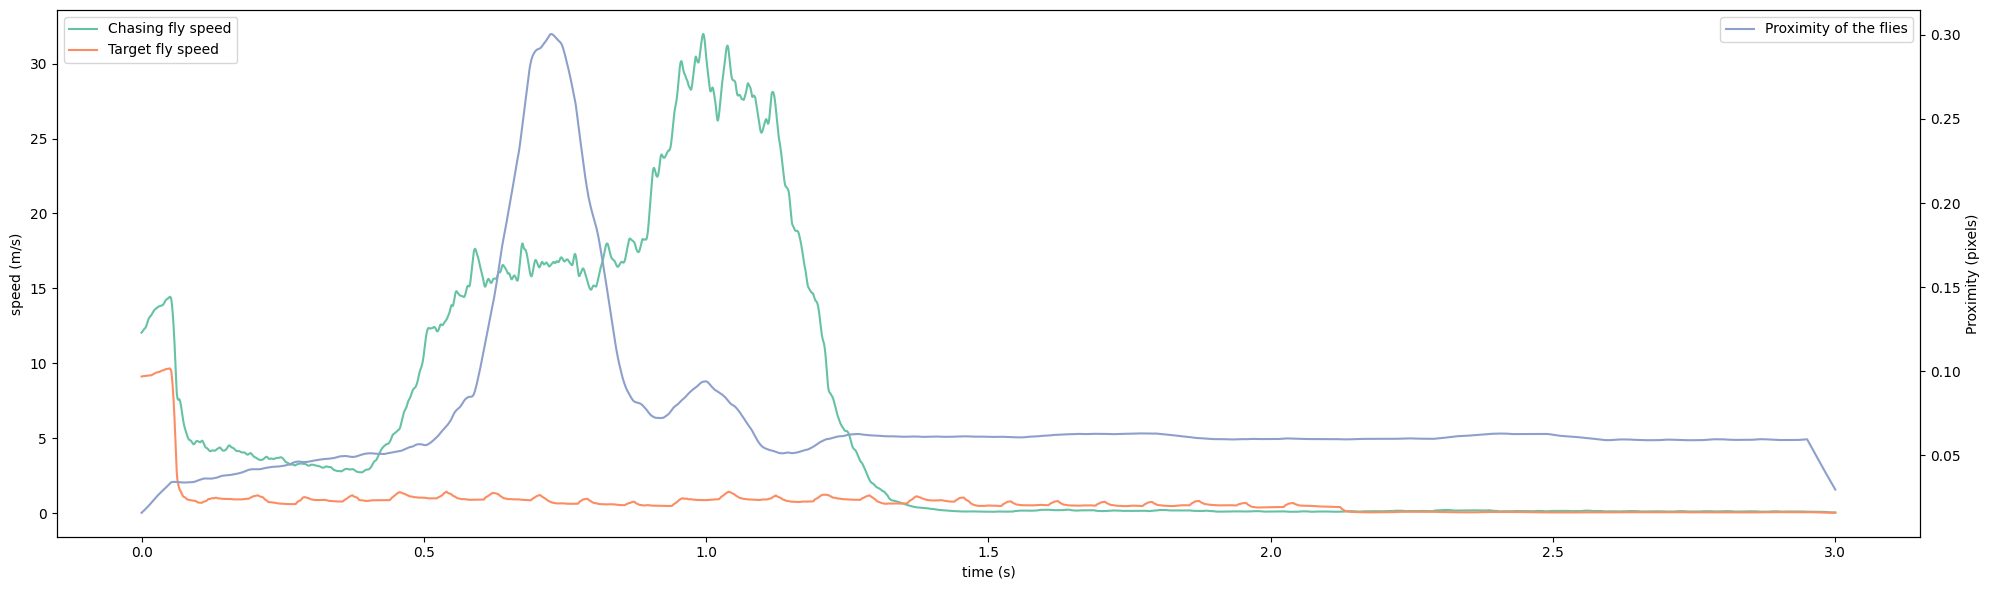

In [12]:
plot_chasing(t, speeds_fly0, speeds_fly1, proximities)

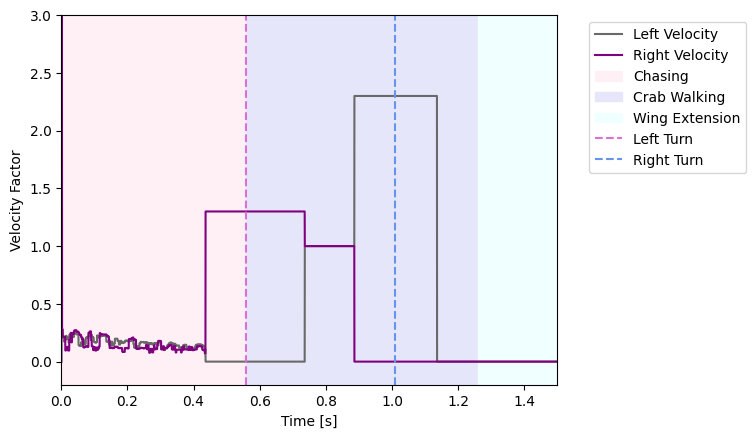

In [13]:
import matplotlib.pyplot as plt

left = [arr[0] for arr in actions_fly0]

# Extract the second values
right = [arr[1] for arr in actions_fly0]

plt.plot(t, left, label = 'Left Velocity', c = 'dimgray')
plt.plot(t, right, label = 'Right Velocity', c = 'purple')
plt.xlim(0, 1.5)
plt.ylim(-0.2, 3)
plt.axvspan(0, 0.56, color = 'lavenderblush', label = 'Chasing' )
plt.axvspan(0.56, 1.26, color = 'lavender', label = 'Crab Walking' )
plt.axvspan(1.26, 1.5, color = 'azure', label = 'Wing Extension' )
plt.axvline(x = 0.56, linestyle = '--',label = 'Left Turn', color = 'orchid')
plt.axvline(x = 1.01, linestyle = '--',label = 'Right Turn', color = 'cornflowerblue')
plt.xlabel('Time [s]')
plt.ylabel('Velocity Factor')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.show()

In [14]:
def plot_overlayed_frames_(birdeye_cam_frames, save=False):
    """
    Plot the overlayed frames of the birdeye camera.

    Parameters
    ----------
    birdeye_cam_frames : numpy array
        The frames of the birdeye camera.
    save : bool
        Whether to save the plot as an image.
    """
    #frame_indices = np.arange(0, len(birdeye_cam_frames), 30)[:8]
    frame_indices = np.linspace(0, len(birdeye_cam_frames), 8, endpoint=False, dtype=int)
    snapshots = [birdeye_cam_frames[i] for i in frame_indices]
    background = np.median(snapshots, axis=0).astype("uint8")

    imgs = []

    for i, img in enumerate(snapshots):
        is_background = np.isclose(img, background, atol=1).all(axis=2)
        img_alpha = np.ones((img.shape[0], img.shape[1], 4)) * 255
        img_alpha[:, :, :3] = img
        img_alpha[is_background, 3] = 0
        img_alpha = img_alpha.astype(np.uint8)
        imgs.append(img_alpha.copy())

    dpi = 72
    h, w = background.shape[:2]

    fig, ax = plt.subplots(figsize=(w / dpi, h / dpi), dpi=72)
    ax.imshow(background)
    ax.axis("off")

    for i, img in enumerate(imgs):
        ax.imshow(img, alpha=(i + 1) / len(imgs))

    fig.subplots_adjust(0, 0, 1, 1, 0, 0)

    if save:
        plt.savefig("outputs/overlayed_frames.png", dpi=dpi)
    else:
        plt.show()

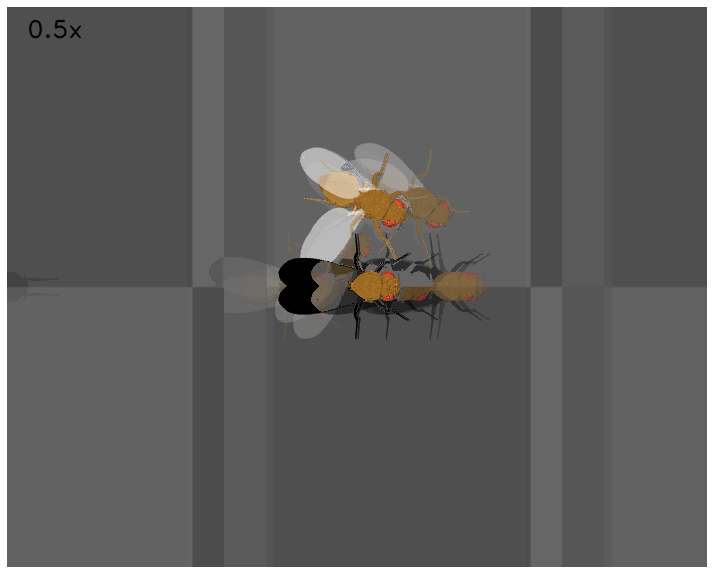

In [15]:
#plot_overlayed_frames(birdeye_cam_frames, save=True)
import matplotlib.pyplot as plt
plot_overlayed_frames_(second_cam_frames, save=True)